In [ ]:
!pip install -U keras tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras as K
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os

### Vanishing/Exploding Gradients Problems

Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem.

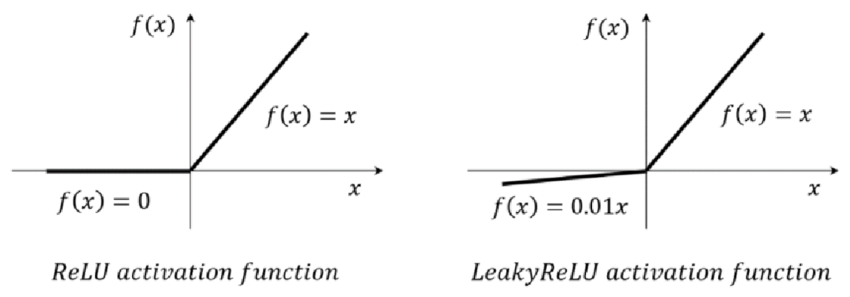

In [ ]:
# Relu
def relu(x):
    return np.maximum(0, x)

# Lekey Relu
def leaky_relu(x):
    return np.maximum(0.1 * x, x)


x = np.array([-1, 2, -3, 4, -5])
print("Relu Output: ", relu(x))
print("Leaky Relu Output: ", leaky_relu(x))

Relu Output:  [0 2 0 4 0]
Leaky Relu Output:  [-0.1  2.  -0.3  4.  -0.5]


In [ ]:
# In Keras
layer = K.layers.Dense(32, activation=relu, kernel_initializer="he_normal")
layer = K.layers.Dense(32, activation=leaky_relu, kernel_initializer="lecun_normal")

In [ ]:
# Initialize Kernel Distribution
layer = K.layers.Dense(32, kernel_initializer="he_normal")
layer = K.layers.Dense(32, kernel_initializer="lecun_normal")
layer = K.layers.Dense(32, kernel_initializer="glorot_normal")

### Batch Normalization

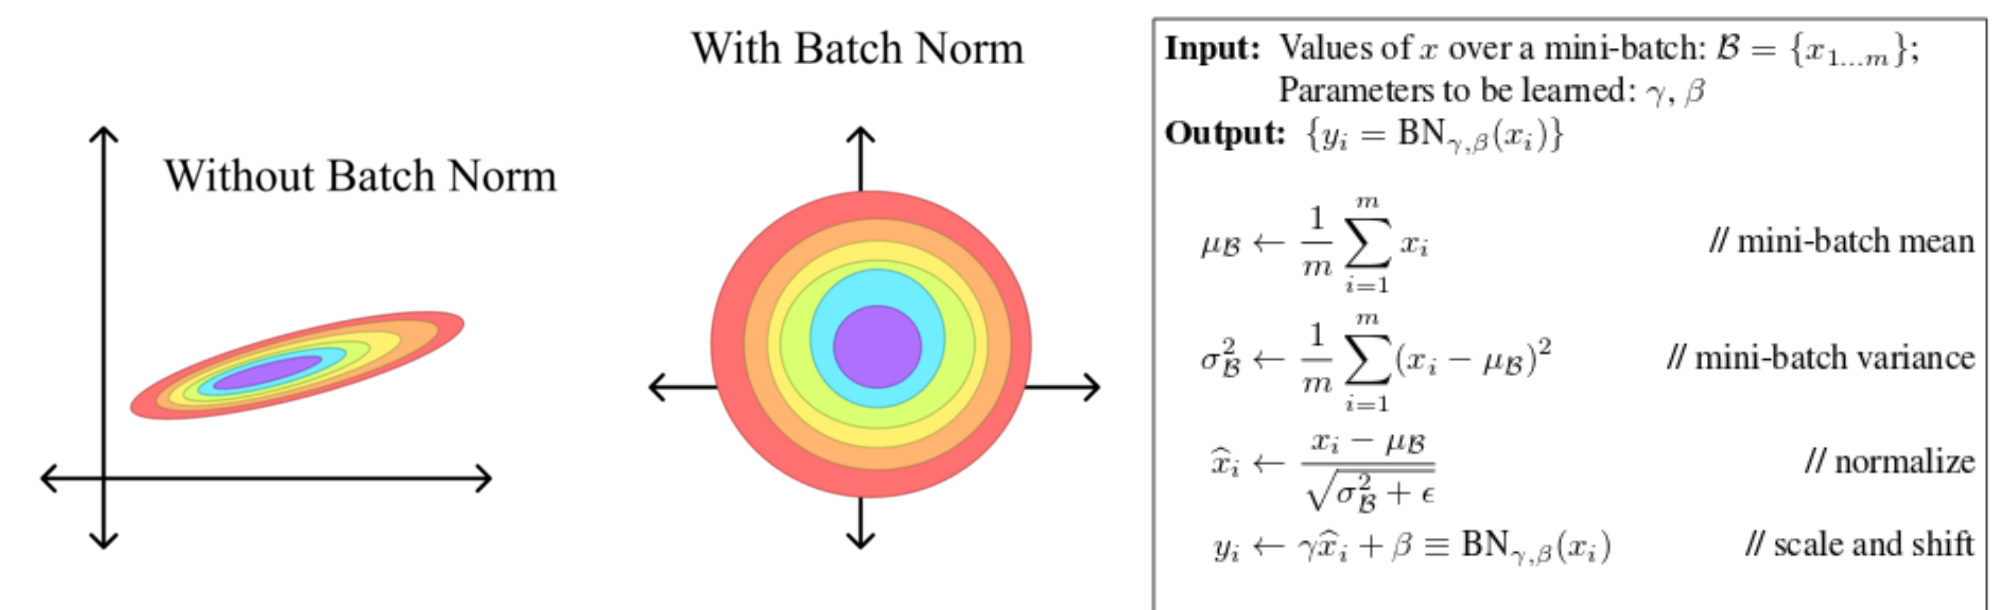

In [ ]:
def batch_normalize(X:np.ndarray, epsilon:float=1e-5):
    mean = np.mean(X, axis=0)
    variance  = np.var(X, axis=0)
    X_norm = (X - mean) / np.sqrt(variance  + epsilon)
    return X_norm


X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(batch_normalize(X))

[[-1.22474385 -1.22474385 -1.22474385]
 [ 0.          0.          0.        ]
 [ 1.22474385  1.22474385  1.22474385]]


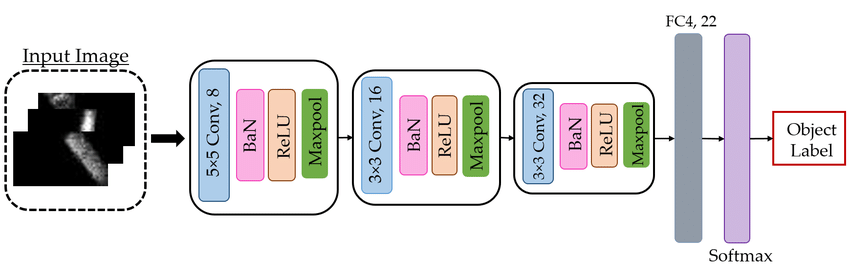

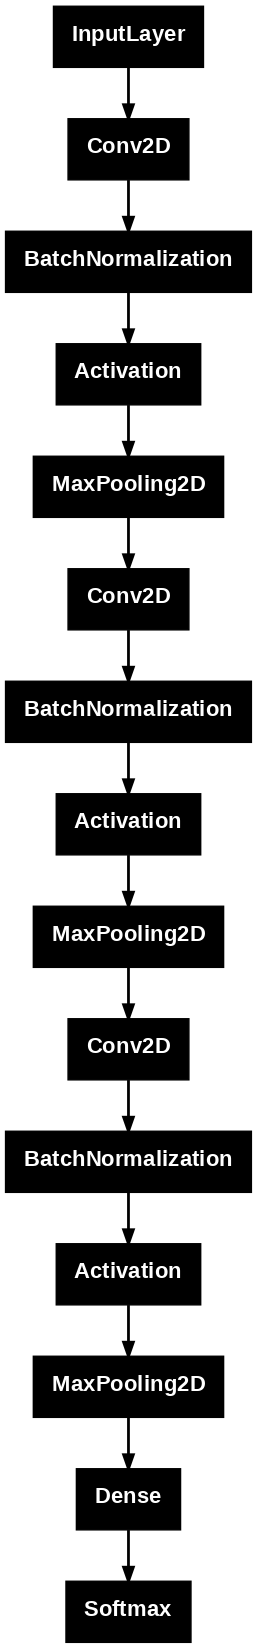

In [ ]:
# Use Batch Normalize In Keras
input = K.layers.Input(shape=(32, 32, 3))
x = K.layers.Conv2D(8, (5,5))(input)
x = K.layers.BatchNormalization(epsilon=0.001)(x) # We can Tune Parameters
x = K.layers.Activation('relu')(x)
x = K.layers.MaxPool2D()(x)

x = K.layers.Conv2D(16, (3,3))(x)
x = K.layers.BatchNormalization(epsilon=2e-4)(x)
x = K.layers.Activation('relu')(x)
x = K.layers.MaxPool2D()(x)

x = K.layers.Conv2D(32, (3,3))(x)
x = K.layers.BatchNormalization(epsilon=2e-2)(x)
x = K.layers.Activation('relu')(x)
x = K.layers.MaxPool2D()(x)

x = K.layers.Dense(22)(x)
x = K.layers.Softmax()(x)

model = K.models.Model(input, x)
K.utils.plot_model(model, dpi=100)

### Gradient Clipping

In [ ]:
def clip_gradient(gradients:np.ndarray, threshold:float):
  grad_norm = np.linalg.norm(gradients)
  if grad_norm > threshold:
    gradients *= threshold / grad_norm
  return gradients


original_gradients = np.array([0.5, 1.2, 3.0, 2.5])
clipped_gradients = clip_gradient(original_gradients, 1.0)
print(clipped_gradients)

[0.12148238 0.29155772 0.7288943  0.60741191]


In [ ]:
# In Keras
optimizer = K.optimizers.SGD(clipnorm=1.0)
optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.009999999776482582,
 'weight_decay': None,
 'clipnorm': 1.0,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'momentum': 0.0,
 'nesterov': False}

### Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called transfer learning.

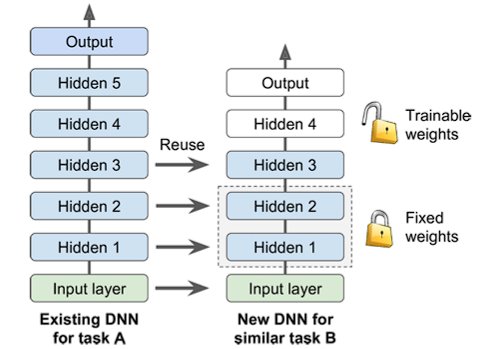

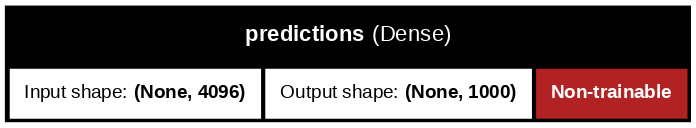

In [ ]:
pretrained_model = K.applications.VGG16(weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

K.utils.plot_model(
    pretrained_model.layers[-1],
    show_shapes=True,
    show_layer_names=True,
    show_trainable=True,
    dpi=100
)

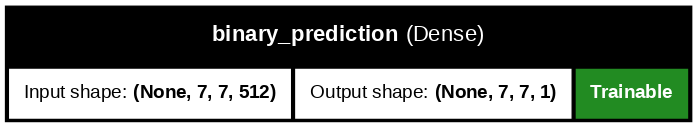

In [ ]:
# Uisng VGG16 for Binary Classification

base_model = K.applications.VGG16(include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = K.layers.Dense(1, activation=tf.nn.sigmoid, name="binary_prediction")(x)
model = K.Model(base_model.input, x)

K.utils.plot_model(
    model.layers[-1],
    show_shapes=True,
    show_layer_names=True,
    show_trainable=True,
    dpi=100
)

### DNNS Optimizers

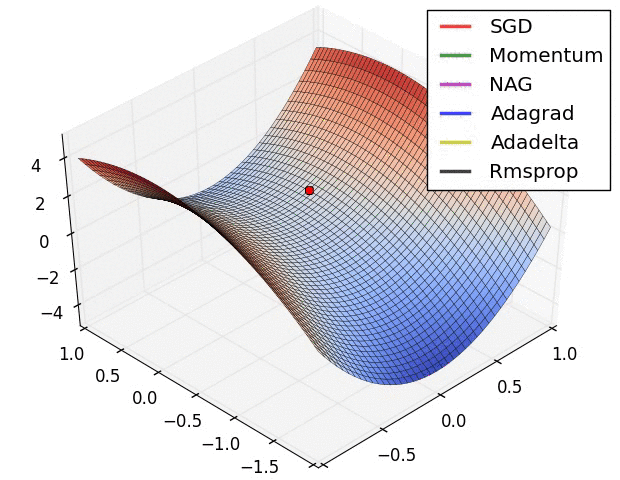

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
x, y = iris.data, iris.target

def monitor_optimizer(optim):
    model = K.Sequential([
      K.Input(shape=(4,)),
      K.layers.Dense(4, activation="relu"),
      K.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        loss=K.losses.SparseCategoricalCrossentropy(),
        optimizer=optim
    )

    hist = model.fit(x, y, epochs=100, verbose=0)
    plt.figure(figsize=(7, 3))
    plt.plot(hist.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Optimizer: {optim.name}")
    plt.show()

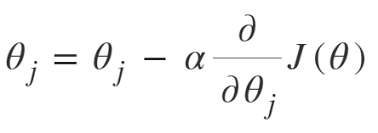

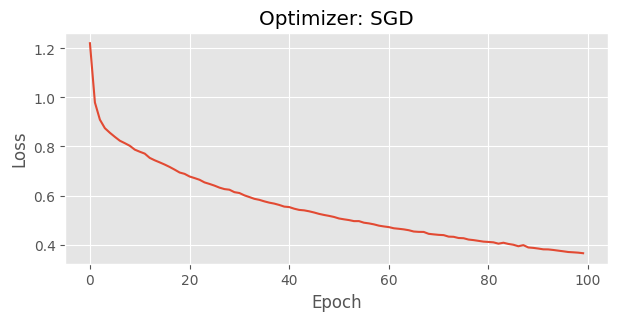

In [ ]:
# SGD Optimizers
sgd = K.optimizers.SGD(learning_rate=0.01)
monitor_optimizer(sgd)

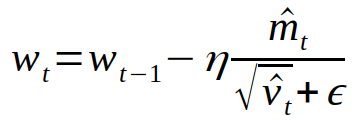

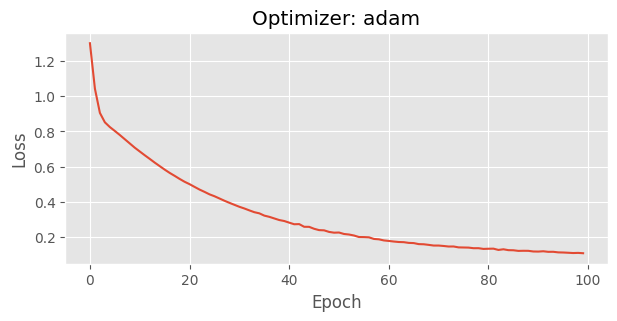

In [ ]:
# Adam Optimizer
adam = K.optimizers.Adam(learning_rate=0.01)
monitor_optimizer(adam)

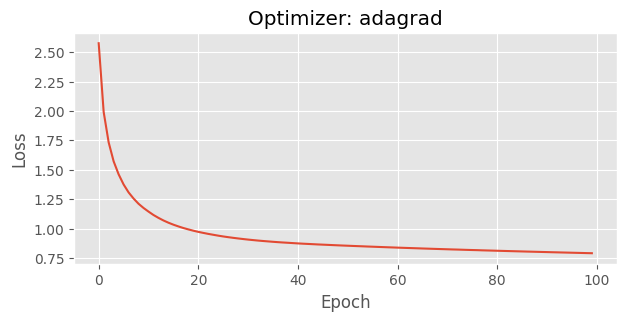

In [ ]:
#AdaGrad
adagrad = K.optimizers.Adagrad(learning_rate=0.01)
monitor_optimizer(adagrad)

In [ ]:
# AdamW
adamw = K.optimizers.AdamW(learning_rate=0.01)
monitor_optimizer(adamw)

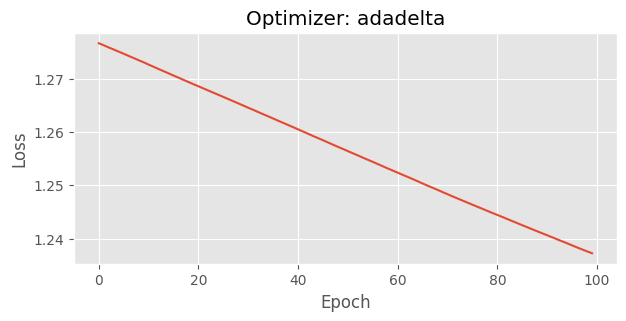

In [ ]:
# Ada Delta
adadelta = K.optimizers.Adadelta(learning_rate=0.01)
monitor_optimizer(adadelta)

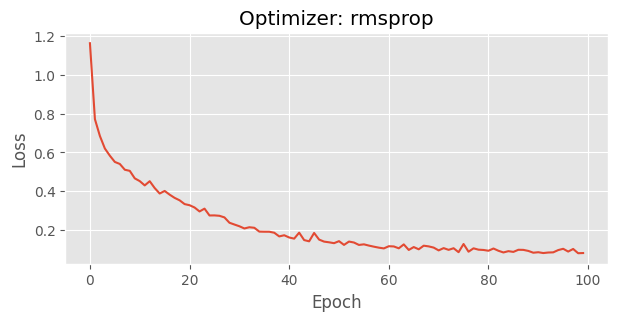

In [ ]:
# RMS Norm
rmsprop = K.optimizers.RMSprop(learning_rate=0.01)
monitor_optimizer(rmsprop)

## Learning Rate

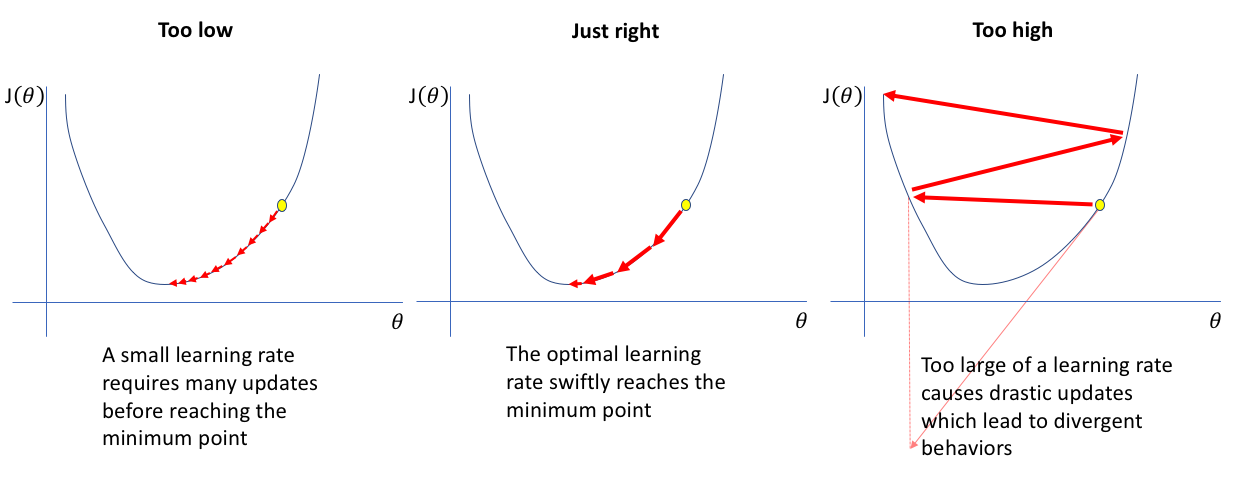

In [ ]:
def monitor_learning_rate(lr):
    model = K.Sequential([
        K.Input(shape=(4,)),
        K.layers.Dense(4, activation="relu"),
        K.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        loss=K.losses.SparseCategoricalCrossentropy(),
        optimizer=K.optimizers.SGD(learning_rate=lr),
        metrics=['accuracy']
    )

    hist = model.fit(x, y, epochs=100, verbose=0)
    plt.figure(figsize=(7, 3))
    plt.plot(hist.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning rate = {}'.format(lr))
    plt.show()

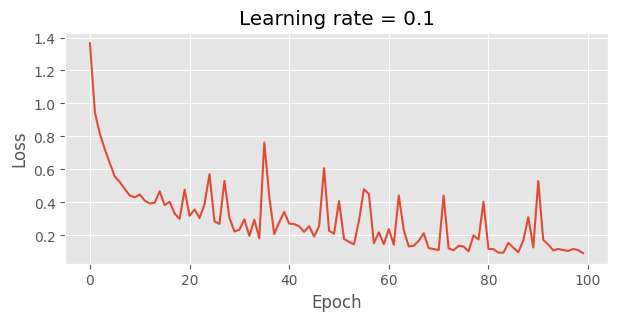

In [ ]:
monitor_learning_rate(0.1)

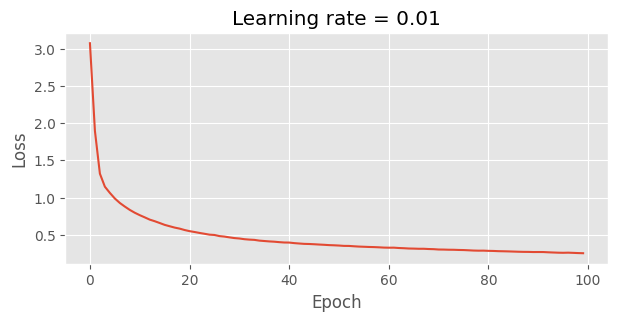

In [ ]:
monitor_learning_rate(0.01)

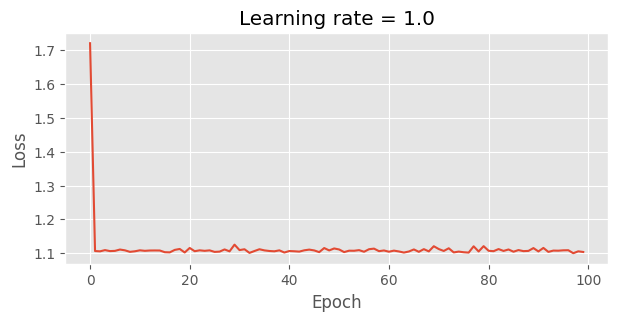

In [ ]:
monitor_learning_rate(1.0)

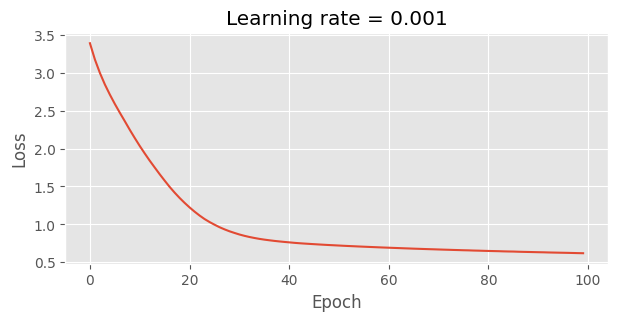

In [ ]:
monitor_learning_rate(0.001)

## Regularizations Techniques

In [ ]:
def experiment_regularization(model):
    model.compile(
        loss=K.losses.SparseCategoricalCrossentropy(),
        optimizer=K.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy']
    )

    hist = model.fit(x, y, validation_split=0.2, epochs=100, verbose=0)
    plt.figure(figsize=(7, 3))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

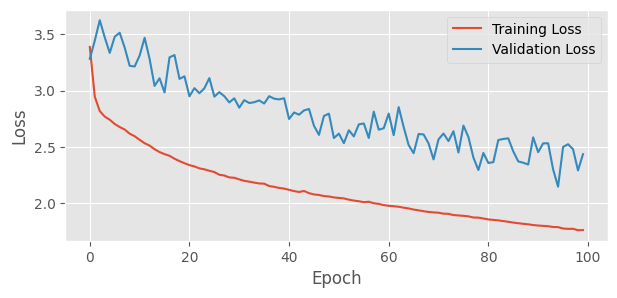

In [ ]:
# L1 Regularizer Model

l1_model = K.Sequential([
    K.Input(shape=(4,)),
    K.layers.Dense(32, activation="relu", kernel_regularizer=K.regularizers.l1(0.01)),
    K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l1(0.01)),
    K.layers.Dense(3, activation='softmax')
])

experiment_regularization(l1_model)

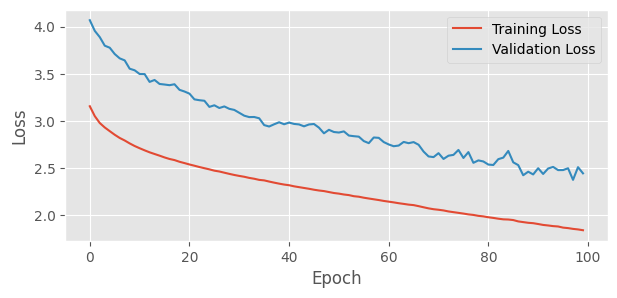

In [ ]:
#L1_L2 Model

l1_l2_model = K.Sequential([
    K.Input(shape=(4,)),
    K.layers.Dense(32, activation="relu", kernel_regularizer=K.regularizers.l1_l2(l1=0.01, l2=0.01)),
    K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l1_l2(l1=0.01, l2=0.01)),
    K.layers.Dense(3, activation='softmax')
])

experiment_regularization(l1_l2_model)

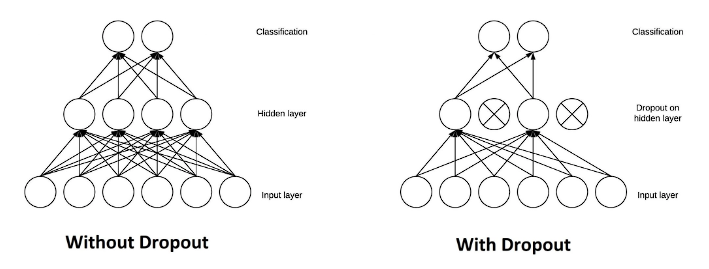

In [ ]:
def dropout(input, p=0.5, training=True):
    if not training:
        return input
    mask = np.random.rand(*input.shape) >= p
    output = (input*mask)/(1-p)
    return output

input = np.random.rand(3, 4)
out = dropout(input, p=0.5, training=True)
pd.DataFrame(out)

,0,1,2,3
0,1.864565,1.643452,0.000000,0.0
1,0.000000,1.747531,0.516103,0.0
2,0.000000,0.076863,0.000000,0.0


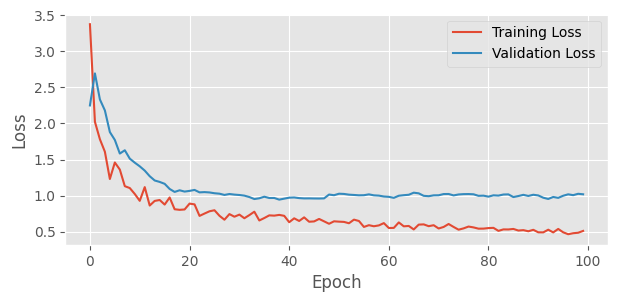

In [ ]:
# Dropout Model

dropout_model= K.Sequential([
    K.Input(shape=(4,)),
    K.layers.Dense(32, activation="relu"),
    K.layers.Dropout(0.5),
    K.layers.Dense(32, activation="relu"),
    K.layers.Dropout(0.5),
    K.layers.Dense(3, activation='softmax')
])

experiment_regularization(dropout_model)